# Diagnóstico de Saúde Geriátrica — Análise Exploratória (EDA)

**Projeto de Extensão Universitária — Home Care / Acompanhamento Crônico**

Este notebook realiza a análise exploratória dos dados **sintéticos** de acompanhamento de idosos, com foco em:
- Análise descritiva da população
- Correlações (incluindo glicemia × velocidade de cicatrização)
- Identificação de padrões de risco (ex.: pressão arterial silenciosa em alta)
- Visualizações para apoio à decisão da enfermeira

*Dados gerados por código — conformidade LGPD e ética em saúde.*

In [1]:
# Bibliotecas para análise de dados e visualização
# pandas: manipulação de dados em tabelas e séries temporais
# numpy: operações numéricas e estatísticas
# matplotlib/seaborn: gráficos para comunicação com a equipe de saúde
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Estilo visual acessível e adequado para relatórios acadêmicos
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 5)
%matplotlib inline

## 1. Carregamento dos dados

Carregamos o CSV gerado pelo script `gerador_dados_pacientes.py`. O caminho é relativo ao diretório do projeto para facilitar reprodutibilidade.

In [2]:
caminho = os.path.join("dados", "dados_sinteticos_idosos.csv")
df = pd.read_csv(caminho, encoding="utf-8-sig")

# Conversão da coluna 'data' para datetime — essencial para séries temporais e ordenação
df["data"] = pd.to_datetime(df["data"])

# Ordenação por paciente e data (garante consistência em análises de tendência)
df = df.sort_values(["id_paciente", "data"]).reset_index(drop=True)

df.head(10)

,id_paciente,data,pressao_sistolica,pressao_diastolica,glicemia_mg_dL,peso_kg,area_curativo_cm2,idade,genero,comorbidade
0,PAC_001,2024-01-01,143.8,96.4,134.8,72.7,20.39,71,F,Hipertensão
1,PAC_001,2024-01-08,126.9,92.2,117.7,73.5,16.95,71,F,Hipertensão
2,PAC_001,2024-01-15,134.6,93.3,110.5,72.8,14.74,71,F,Hipertensão
3,PAC_001,2024-01-22,145.1,94.7,101.1,73.9,12.47,71,F,Hipertensão
4,PAC_001,2024-01-29,129.2,88.8,137.1,74.2,10.66,71,F,Hipertensão
5,PAC_001,2024-02-05,127.7,94.0,90.6,73.4,9.14,71,F,Hipertensão
6,PAC_001,2024-02-12,141.1,92.8,123.7,73.4,8.09,71,F,Hipertensão
7,PAC_001,2024-02-19,128.9,78.6,93.1,75.9,6.80,71,F,Hipertensão
8,PAC_001,2024-02-26,134.1,80.1,117.3,72.4,5.84,71,F,Hipertensão
9,PAC_001,2024-03-04,145.6,86.8,129.1,74.4,5.20,71,F,Hipertensão


## 2. Análise descritiva da população sintética

A estatística descritiva permite caracterizar a amostra (idade, comorbidades, variáveis clínicas) e verificar a presença de valores ausentes ou extremos antes de inferências. Em projetos de saúde, isso corresponde ao "perfil da população atendida".

In [3]:
# Resumo por paciente (uma linha por id) para descrever a POPULAÇÃO
# Usamos a primeira ocorrência de cada paciente para idade, gênero e comorbidade
pacientes_unicos = df.drop_duplicates(subset="id_paciente", keep="first")

print("=== Tamanho da amostra ===")
print(f"Número de pacientes: {pacientes_unicos.shape[0]}")
print(f"Registros de acompanhamento (visitas semanais): {len(df)}")
print()

print("=== Distribuição por comorbidade ===")
print(pacientes_unicos["comorbidade"].value_counts())
print()

print("=== Distribuição por gênero ===")
print(pacientes_unicos["genero"].value_counts())
print()

print("=== Estatísticas descritivas — variáveis numéricas (por visita) ===")
df[["pressao_sistolica", "pressao_diastolica", "glicemia_mg_dL", "peso_kg", "area_curativo_cm2", "idade"]].describe()

=== Tamanho da amostra ===
Número de pacientes: 30
Registros de acompanhamento (visitas semanais): 780

=== Distribuição por comorbidade ===
comorbidade
Hipertensão    15
Diabetes       10
Nenhuma         5
Name: count, dtype: int64

=== Distribuição por gênero ===
genero
F    15
M    15
Name: count, dtype: int64

=== Estatísticas descritivas — variáveis numéricas (por visita) ===


,pressao_sistolica,pressao_diastolica,glicemia_mg_dL,peso_kg,area_curativo_cm2,idade
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,133.005513,82.366923,109.433846,71.301026,4.724013,80.300000
std,15.141014,8.270867,27.775177,7.881487,4.506016,8.883196
min,98.800000,60.000000,70.000000,54.800000,0.500000,66.000000
25%,122.300000,76.600000,91.175000,65.175000,1.330000,72.000000
50%,131.600000,81.250000,104.600000,70.950000,3.095000,83.500000
75%,143.700000,88.225000,121.050000,78.825000,6.730000,88.000000
max,179.100000,110.000000,237.400000,84.300000,21.580000,94.000000


In [4]:
# Verificação de integridade: dados sintéticos não devem ter missings
# Em dados reais, esta etapa é crítica para decidir imputação ou exclusão
print("Valores ausentes por coluna:")
print(df.isnull().sum())

Valores ausentes por coluna:
id_paciente           0
data                  0
pressao_sistolica     0
pressao_diastolica    0
glicemia_mg_dL        0
peso_kg               0
area_curativo_cm2     0
idade                 0
genero                0
comorbidade           0
dtype: int64


## 3. Identificação de padrões e correlações

A **matriz de correlação** (Pearson) mede associação linear entre variáveis numéricas. Em saúde geriátrica, esperamos, por exemplo: correlação positiva entre pressão sistólica e diastólica; possível associação negativa entre controle glicêmico e velocidade de cicatrização (quanto maior a glicemia média, menor a redução da área do curativo).

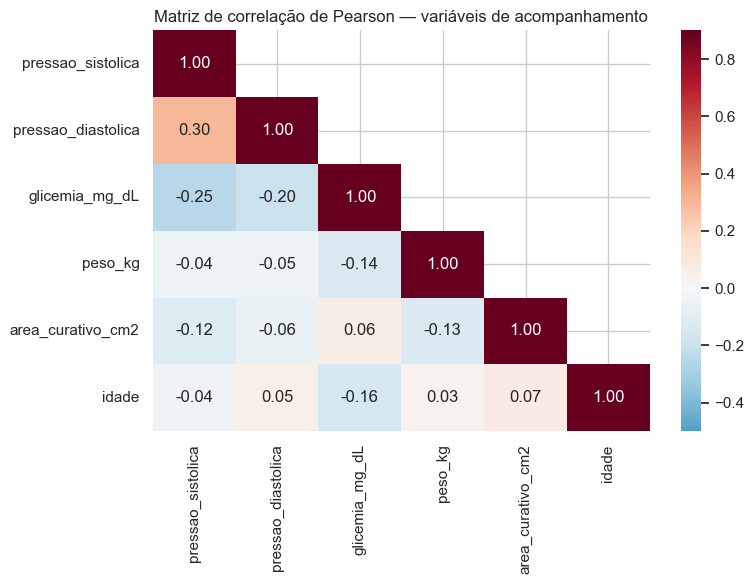

In [5]:
# Variáveis numéricas contínuas para correlação
cols_num = ["pressao_sistolica", "pressao_diastolica", "glicemia_mg_dL", "peso_kg", "area_curativo_cm2", "idade"]
corr = df[cols_num].corr(method="pearson")

# Máscara para exibir apenas o triângulo inferior e evitar redundância visual
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r", center=0, vmin=-0.5, vmax=0.9, ax=ax)
plt.title("Matriz de correlação de Pearson — variáveis de acompanhamento")
plt.tight_layout()
plt.show()

### 3.1 Correlação entre glicemia e velocidade de cicatrização

A **velocidade de cicatrização** pode ser operacionalizada como a redução total da área do curativo ao longo do acompanhamento (ou a taxa média semanal). Quanto maior a glicemia média do paciente no período, menor tende a ser essa redução — refletindo o efeito da hiperglicemia na cicatrização. Calculamos por paciente: **glicemia média** e **redução total da área** (área inicial − área final).

In [6]:
# Por paciente: primeira e última visita para área inicial e final
area_inicial = df.groupby("id_paciente")["area_curativo_cm2"].first()
area_final   = df.groupby("id_paciente")["area_curativo_cm2"].last()
reducao_area = (area_inicial - area_final).rename("reducao_area_cm2")

# Glicemia média no período (proxy de "controle glicêmico")
glicemia_media = df.groupby("id_paciente")["glicemia_mg_dL"].mean().rename("glicemia_media")

# DataFrame por paciente para correlação e scatter
df_paciente = pd.DataFrame({"glicemia_media": glicemia_media, "reducao_area_cm2": reducao_area})

# Correlação de Pearson: esperamos valor negativo (mais glicemia → menos redução)
r = df_paciente["glicemia_media"].corr(df_paciente["reducao_area_cm2"])
print(f"Correlação glicemia média × redução da área do curativo: r = {r:.3f}")
print("Interpretação: r < 0 indica que maior glicemia média está associada a menor redução da área (cicatrização mais lenta).")

Correlação glicemia média × redução da área do curativo: r = 0.222
Interpretação: r < 0 indica que maior glicemia média está associada a menor redução da área (cicatrização mais lenta).


## 4. Análise de risco: pressão arterial com tendência de alta (silenciosa)

Em anotações de papel, subidas graduais da pressão ao longo das semanas podem passar despercebidas. Identificamos pacientes com **tendência de alta** na pressão sistólica ao longo do tempo usando regressão linear por paciente: o coeficiente angular (slope) positivo indica que a PA está subindo em média a cada semana. Pacientes com slope acima de um limiar são sinalizados para revisão.

In [7]:
# Número de semana (0, 1, 2, ...) como variável temporal para regressão
def slope_pa_sistolica(serie):
    """Coeficiente angular da regressão PA sistólica ~ semana. Positivo = tendência de alta."""
    x = np.arange(len(serie))
    if len(serie) < 2:
        return np.nan
    # Regressão linear: y = ax + b; queremos 'a' (slope)
    a = np.polyfit(x, serie.values, 1)[0]
    return a

tendencia_pa = df.groupby("id_paciente")["pressao_sistolica"].apply(slope_pa_sistolica)
# Limiar: subida de 0,3 mmHg por semana em 6 meses ≈ 4 mmHg — clinicamente relevante
limiar_semanal = 0.3
pacientes_risco_pa = tendencia_pa[tendencia_pa >= limiar_semanal].sort_values(ascending=False)

print("Pacientes com tendência de ALTA na pressão sistólica (possível risco silencioso):")
print(pacientes_risco_pa.to_string())
print(f"\nTotal sinalizados: {len(pacientes_risco_pa)} pacientes.")

Pacientes com tendência de ALTA na pressão sistólica (possível risco silencioso):
id_paciente
PAC_017    0.562701
PAC_030    0.534632
PAC_008    0.488923
PAC_001    0.483795
PAC_002    0.406803
PAC_021    0.350154
PAC_028    0.339726

Total sinalizados: 7 pacientes.


## 5. Visualização para decisão clínica

Gráficos de **séries temporais** (linha) permitem à enfermeira visualizar a evolução de pressão e glicemia ao longo do tempo. Comparar dois pacientes com perfis diferentes (ex.: um com Diabetes e outro com Hipertensão) ilustra como as comorbidades se refletem nos dados.

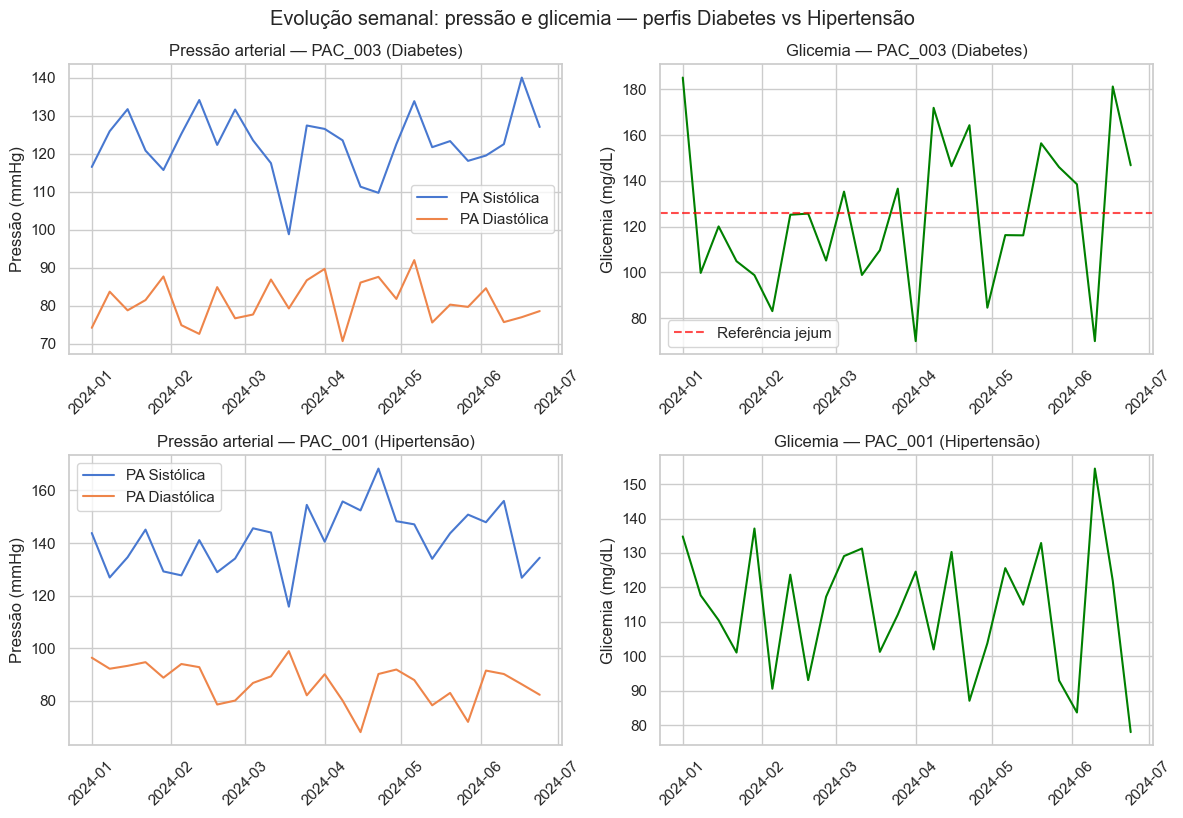

In [8]:
# Escolhemos 2 pacientes de perfis distintos: um com Diabetes e outro com Hipertensão
perfil_diabetes = pacientes_unicos[pacientes_unicos["comorbidade"] == "Diabetes"]["id_paciente"].iloc[0]
perfil_hipertensao = pacientes_unicos[pacientes_unicos["comorbidade"] == "Hipertensão"]["id_paciente"].iloc[0]

df_diab = df[df["id_paciente"] == perfil_diabetes].copy()
df_hip  = df[df["id_paciente"] == perfil_hipertensao].copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Paciente com Diabetes: PA e Glicemia
axes[0, 0].plot(df_diab["data"], df_diab["pressao_sistolica"], label="PA Sistólica", color="C0")
axes[0, 0].plot(df_diab["data"], df_diab["pressao_diastolica"], label="PA Diastólica", color="C1")
axes[0, 0].set_title(f"Pressão arterial — {perfil_diabetes} (Diabetes)")
axes[0, 0].set_ylabel("Pressão (mmHg)")
axes[0, 0].legend()
axes[0, 0].tick_params(axis="x", rotation=45)

axes[0, 1].plot(df_diab["data"], df_diab["glicemia_mg_dL"], color="green")
axes[0, 1].set_title(f"Glicemia — {perfil_diabetes} (Diabetes)")
axes[0, 1].set_ylabel("Glicemia (mg/dL)")
axes[0, 1].axhline(y=126, color="red", linestyle="--", alpha=0.7, label="Referência jejum")
axes[0, 1].legend()
axes[0, 1].tick_params(axis="x", rotation=45)

# Paciente com Hipertensão: PA e Glicemia
axes[1, 0].plot(df_hip["data"], df_hip["pressao_sistolica"], label="PA Sistólica", color="C0")
axes[1, 0].plot(df_hip["data"], df_hip["pressao_diastolica"], label="PA Diastólica", color="C1")
axes[1, 0].set_title(f"Pressão arterial — {perfil_hipertensao} (Hipertensão)")
axes[1, 0].set_ylabel("Pressão (mmHg)")
axes[1, 0].legend()
axes[1, 0].tick_params(axis="x", rotation=45)

axes[1, 1].plot(df_hip["data"], df_hip["glicemia_mg_dL"], color="green")
axes[1, 1].set_title(f"Glicemia — {perfil_hipertensao} (Hipertensão)")
axes[1, 1].set_ylabel("Glicemia (mg/dL)")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.suptitle("Evolução semanal: pressão e glicemia — perfis Diabetes vs Hipertensão", y=1.02)
plt.show()

### 5.1 Dispersão: idade e glicemia vs tempo/capacidade de cicatrização

O **scatter plot** relaciona duas variáveis contínuas. Aqui: no eixo X usamos **idade** ou **glicemia média**; no eixo Y, a **redução total da área do curativo** (proxy do “tempo/velocidade de cicatrização”). Isso ajuda a comunicar que idades mais altas ou pior controle glicêmico podem estar associados a menor redução da ferida.

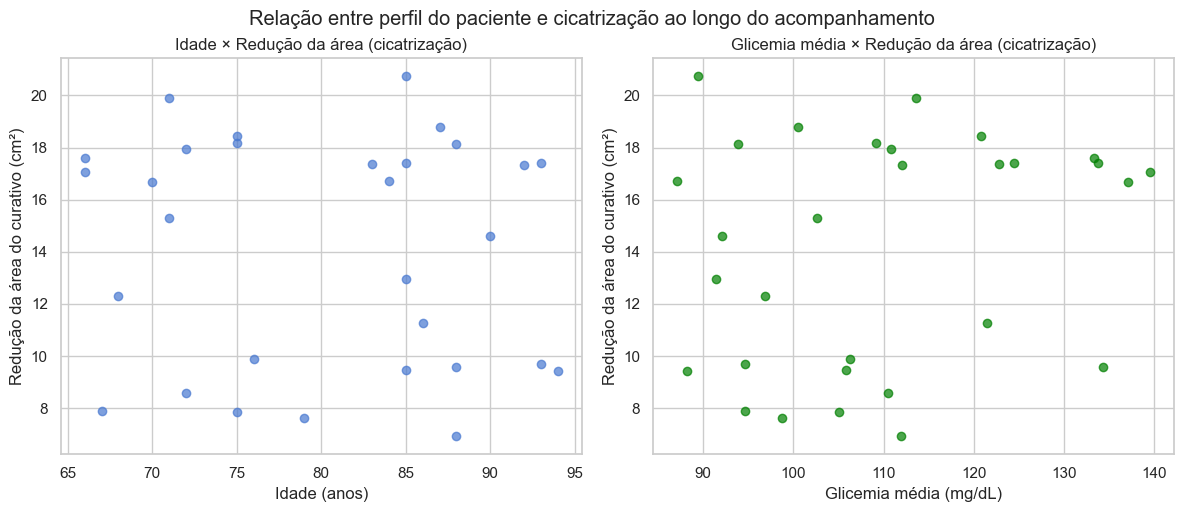

In [9]:
# Incluir idade no df por paciente (para o scatter)
idade_pac = df.groupby("id_paciente")["idade"].first()
df_paciente["idade"] = df_paciente.index.map(idade_pac)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Idade vs redução da área
axes[0].scatter(df_paciente["idade"], df_paciente["reducao_area_cm2"], alpha=0.7)
axes[0].set_xlabel("Idade (anos)")
axes[0].set_ylabel("Redução da área do curativo (cm²)")
axes[0].set_title("Idade × Redução da área (cicatrização)")

# Glicemia média vs redução da área
axes[1].scatter(df_paciente["glicemia_media"], df_paciente["reducao_area_cm2"], alpha=0.7, color="green")
axes[1].set_xlabel("Glicemia média (mg/dL)")
axes[1].set_ylabel("Redução da área do curativo (cm²)")
axes[1].set_title("Glicemia média × Redução da área (cicatrização)")

plt.tight_layout()
plt.suptitle("Relação entre perfil do paciente e cicatrização ao longo do acompanhamento", y=1.02)
plt.show()

## Considerações para o relatório de extensão

- **Estatística descritiva:** caracteriza a população e garante qualidade dos dados antes de análises.
- **Correlação de Pearson:** quantifica associação linear; em saúde, usada para hipóteses como glicemia × cicatrização.
- **Regressão linear por paciente (slope):** técnica simples para detectar tendência temporal (ex.: PA subindo ao longo das semanas), útil para risco “silencioso”.
- **Séries temporais (gráficos de linha):** permitem à enfermeira acompanhar evolução e comparar perfis (Diabetes vs Hipertensão).
- **Scatter plot:** comunica relação entre duas variáveis (idade ou glicemia vs resultado de cicatrização) de forma intuitiva para a equipe.